# Visualize Data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dataset len 160


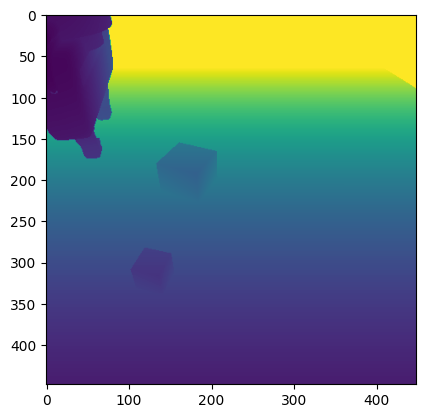

In [60]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from data_loader_h5 import H5Dataset
from data_loader_jsonl import JSONLDataset, ValidDataset
from data_loader_images import ImageFolderDataset
from data_augmentations import RandomizeBackgrounds, augment_image_rgb, complexify_text, DepthAugmentation

return_depth = True
depth_to_color = False
dataset_location = "/tmp/clevr-act-7-depth"

depth_augment = DepthAugmentation()
sim_dataset = H5Dataset(dataset_location, return_depth=return_depth, augment_depth=depth_augment, depth_to_color=depth_to_color)
#randomize_background = RandomizeBackgrounds(p=0.2, background_images = "/tmp/indoorCVPR/Images")
#train_dataset = H5Dataset(dataset_location, augment_rgbds=randomize_background, augment_rgb=augment_image_rgb, augment_text=complexify_text)


#dataset_location = Path("/tmp/clevr-act-7-depth")
#randomize_background = RandomizeBackgrounds(p=0.2, background_images = "/tmp/indoorCVPR/Images")
#train_dataset = H5Dataset(dataset_location, augment_rgbds=randomize_background, augment_rgb=augment_image_rgb)

#dataset_location = "/data/lmbraid19/argusm/datasets/clevr-real-1of5c-v1"
#train_dataset = JSONLDataset(dataset_location, return_depth=return_depth)

dataset_location = "/data/lmbraid19/argusm/datasets/clevr-real-block-v3"
real_dataset = JSONLDataset(dataset_location, return_depth=return_depth, depth_to_color=depth_to_color)

plt.imshow(sim_dataset[0][0][0])
print("dataset len", len(real_dataset))

Real Samples: 160


  0%|          | 0/9 [00:00<?, ?it/s]


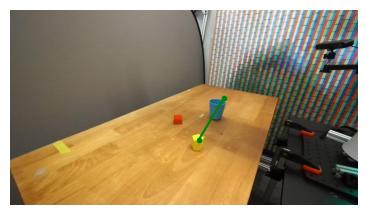
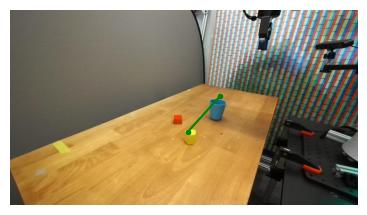
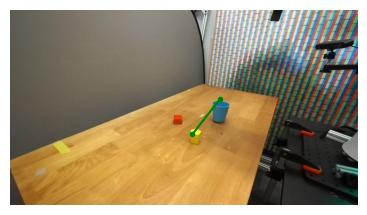
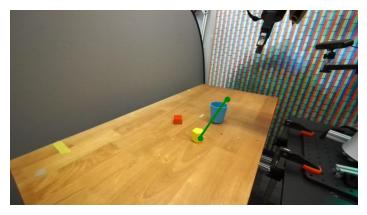
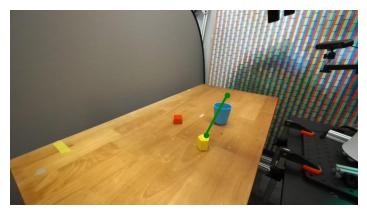
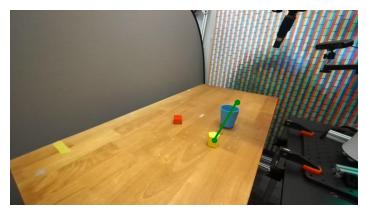
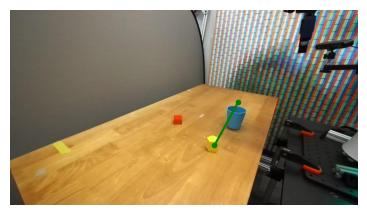
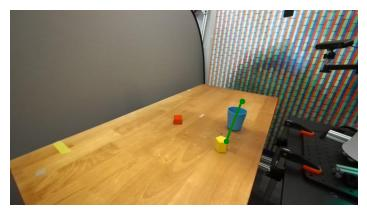
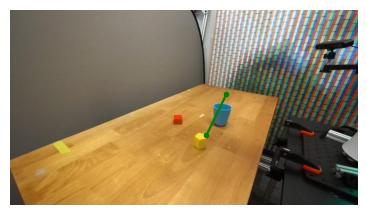

In [7]:
from IPython.display import display, HTML
from tqdm.notebook import tqdm
from utils_vis import render_example

def get_image(images):
    if isinstance(images, (list, tuple)):
        return images[-1]
    else:
        return images
    
def get_depth(images):
    if isinstance(images, (list, tuple)):
        return images[0]
    else:
        return None
    
print("Real Samples:", len(real_dataset))
num_samples = min(3*3, len(real_dataset))
html_imgs = ""
for i in tqdm(range(num_samples)):
    images, sample = real_dataset[i]
    image = get_image(images)
    html_imgs += render_example(image, label=sample["suffix"], text=sample["prefix"], camera=sample["camera"])
    
display(HTML(html_imgs))

# Quick Depth Plot

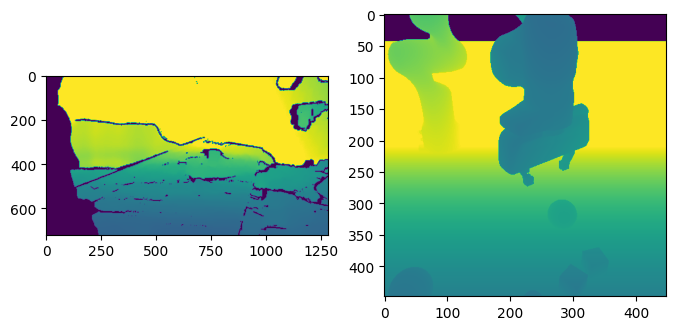

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from data_augmentations import depth_to_norm, norm_to_color
from PIL import Image


images, sample = real_dataset[0]
real_depth_image = get_depth(images)
if depth_to_color:
    real_depth_image = (real_depth_image*255).round().astype(np.uint8)
    real_depth_image = Image.fromarray(real_depth_image).resize((448,448))

images, sample = sim_dataset[2]
sim_depth_image = get_depth(images)

fig, ax = plt.subplots(1,2, figsize=(8, 8*1/2))
ax[0].imshow(np.clip(real_depth_image, 0, 1023))
ax[1].imshow(np.clip(sim_depth_image, 0,1023))
plt.show()

In [9]:
from tqdm.notebook import tqdm
def get_non_zero_min(arr):
    return arr[arr!=0].min()

real_mins = []
sim_mins = []

for i in tqdm(range(len(real_dataset))):
    images, sample = real_dataset[i]
    real_depth_image = get_depth(images)
    real_mins.append(get_non_zero_min(real_depth_image))
    images, sample = sim_dataset[i]
    sim_depth_image = get_depth(images)
    sim_mins.append(get_non_zero_min(sim_depth_image))

plt.plot(sorted(real_mins), label="real")
plt.plot(sorted(sim_mins), label="sim")
plt.legend()
plt.show()

  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import inspect
inspect.getfile(render_example)

In [67]:
from copy import copy
from tqdm.notebook import tqdm
from data_augmentations import  color_to_norm, norm_to_depth

results = {}
for name, dataset in zip(("real", "sim"), (real_dataset, sim_dataset)):
    num_samples = min(len(dataset), 160)
    all_tcp_zs = []
    all_depths = []
    for i in tqdm(range(num_samples)):
        (depth, image), sample = dataset[i]
        #curve_25d, quat_c = decode_caption_xyzrotvec2(sample["suffix"], sample["camera"])
        curve_25d, quat_c = dataset.action_encoder.decode_caption(sample["suffix"], sample["camera"])
        x, y = curve_25d[0][:2].round().numpy().astype(int)
        tcp_z_m = curve_25d[0][2].numpy()
        x = np.clip(x, 0, depth.shape[1]-1)
        y = np.clip(y, 0, depth.shape[0]-1)
        if depth.ndim == 3:
            image_depth_color = tuple(depth[y, x])
            image_depth_norm = color_to_norm(image_depth_color)
            image_depth_m = norm_to_depth(image_depth_norm) / 1000
        else:
            image_depth_m = depth[y, x] / 1000

        if image_depth_m == 0:
            continue
        all_tcp_zs.append(tcp_z_m)
        all_depths.append(image_depth_m)
    results[name] = dict(tcp_zs=np.array(all_tcp_zs), depths=np.array(all_depths))


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

real	 y=1.0119 x + -0.0189
sim	 y=0.9742 x + -0.0134


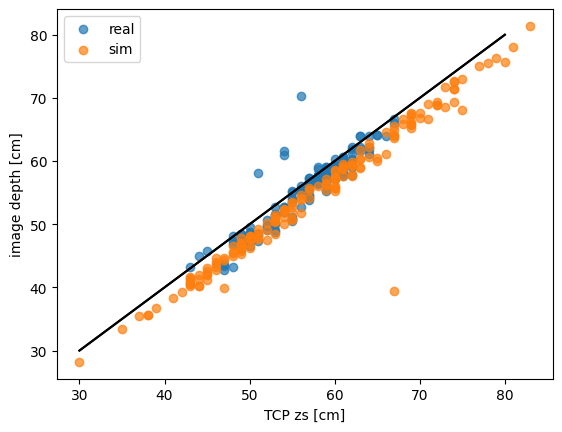

In [68]:
fig, ax = plt.subplots(1)
for name, res in results.items():
    m ,b = np.polyfit(res["tcp_zs"], res["depths"], 1)
    print(f"{name}\t y={m:.4f} x + {b:.4f}")
    s = 100
    if name == "sim":
        offset_m = 0.05
        offset_m = 0
        ax.scatter(res["tcp_zs"]*s,(res["depths"]+offset_m)*s, label=name, alpha=.7)
    else:
        ax.scatter(res["tcp_zs"]*s,res["depths"]*s, label=name, alpha=.7)
    ax.set_xlabel("TCP zs [cm]")
    ax.set_ylabel("image depth [cm]")

    ax.plot((.3*s,.8*s),(.3*s,.8*s), color='k')

plt.legend()
plt.show()

In [41]:
results

{'real': {'tcp_zs': array([], dtype=float64),
  'depths': array([], dtype=float64)},
 'sim': {'tcp_zs': array([], dtype=float64),
  'depths': array([], dtype=float64)}}

In [ ]:

rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 12*2/3))  # 3 rows x 4 columns of histograms
for c in range(cols):
    (depth, image), sample = real_dataset[c]
    curve_25d, quat_c = decode_caption_xyzrotvec2(sample["suffix"], sample["camera"])
    x,y = curve_25d[0][:2].round().numpy().astype(int)
    depth_val = curve_25d[0][2].numpy()

    if depth.ndim == 3:
        depth_color = tuple(depth[y, x])
        depth_norm_float = color_to_norm(depth_color)
        depth_float = norm_to_depth(depth_norm_float)
    else:
        depth_float = depth[y, x] * 1023 / 10
    
    print(depth_float, depth_val)
    
    d = curve_25d[0][2]
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    for r in range(rows//2):
        axes[r][c].imshow(depth)
        circle = plt.Circle((x, y), 20, color='magenta', fill=False)
        axes[r][c].add_patch(circle)  # Add circle to the image subplot

        axes[r][c].set_title("depth")
        axes[r+1][c].imshow(image)
        axes[r+1][c].set_title(sample["prefix"].split("<")[0])
        circle = plt.Circle((x, y), 20, color='magenta', fill=False)
        axes[r+1][c].add_patch(circle)  # Add circle to the image subplot


# Plane Detection

In [ ]:
#%pip install open3d
import numpy as np
import open3d as o3d

depth_augment = DepthAugmentation()

dataset = JSONLDataset(dataset_location, return_depth=return_depth, augment_depth=depth_augment, depth_to_color=False)
sample = dataset[10]
rgb_image = sample[0][1]
depth_image = sample[0][0]
width, height = rgb_image.size
intrinsic = sample[1]["camera"].get_intrinsic_matrix()[0].numpy()
camera = o3d.camera.PinholeCameraIntrinsic(width, height, intrinsic)

color_as_img = o3d.geometry.Image(np.asarray(rgb_image))
depth_as_img = o3d.geometry.Image((depth_image))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_as_img, depth_as_img)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera)

nb_neighbors=20
std_ratio=2.0
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)


pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)
print("done.")

# ManiSkill H5 Datasets

In [ ]:
import glob
from pathlib import Path
import h5py

def print_h5_structure(name, obj):
    """
    Prints the path, type, and shape of each member in an h5 file.
    """
    # Check if the object is a dataset
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name} | Shape: {obj.shape} | Type: {obj.dtype}")
    # If it's a group, just print its name
    elif isinstance(obj, h5py.Group):
        print(f"Group: {name}")

traj_path = Path("/data/lmbraid19/argusm/datasets/clevr-act-9-ms-small/20250205_182607.h5")
idx = 0

with h5py.File(traj_path, "r") as h5_file:
    print(h5_file['traj_0/obs/sensor_param/render_camera'].keys())
    print_h5_structure(f"traj_{idx}", h5_file)

In [ ]:
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

h5_tree(real_dataset.h5_file)